# 第2回　ロジスティック回帰
3月17日　石村

## データセット
irisデータ

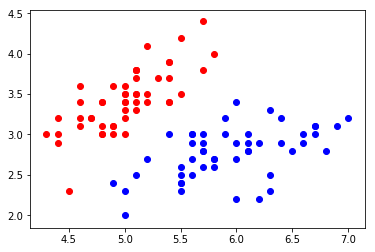

In [2]:
from utility import *

mydata = MyData(data_type='clf')
mydata.plot_data()

In [3]:
X, y = mydata.get_dataset()

# scikit-learnのロジスティック回帰

In [4]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=9)
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=9, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [5]:
lr.coef_

array([[ 3.0786959, -3.0220097]])

In [6]:
lr.intercept_

array([-7.30634549])

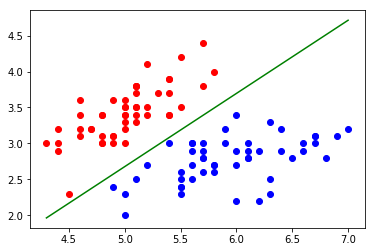

In [8]:
mydata.plot_boundary(lr.coef_[0], lr.intercept_)

# 自力で実装

In [12]:
import numpy as np

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def calc_loss(y_true, y_pred):
    eps = 1e-15
    loss = -(-y_true * np.log(y_pred-eps) + (1-y_true) * np.log(1-y_pred+eps)).mean()
    return loss

def update_params(w, X, proba, y, lr):
    gradient = (X.T @ (proba - y))
    w = w - lr / len(X) * gradient
    return w


class MyLogisticRegression():
    def __init__(self, fit_intercept=True):
        self.w = None
        self.X = None
        self.y_true = None
        self.fit_intercept=fit_intercept
        return
    
    def initialize_params(self, size):
        # np.random.seed(seed=32)
        return np.random.rand(size)
    
    def add_const(self, X):
        return np.hstack((X, np.ones((len(X), 1))))
    
    def fit(self, X, y):
        if self.fit_intercept:
            self.X = self.add_const(X)
        self.y_true = y
        self.w = self.initialize_params(self.X.shape[1])
        
        lr = 0.01
        max_itr = 10000
        loss_hist = float('inf')
        for i in range(max_itr):
            y_proba = self.predict_proba(self.X)
            log_loss = calc_loss(self.y_true, y_proba)
            if log_loss > loss_hist:
                break
            loss_hist = min(loss_hist, log_loss)
            self.w = update_params(self.w, self.X, y_proba, self.y_true, lr)
        
    def predict_proba(self, X):
        if self.fit_intercept:
            return sigmoid(self.X @ self.w)
        else:
            return sigmoid(X @ self.w)
    
    def score(self, X, y):
        y_pred = (self.predict_proba(X) > 0.5) * 1
        return (y_pred == y).sum() / len(y)

In [13]:
mlr = MyLogisticRegression()
mlr.fit(X, y)
mlr.score(X, y)

0.99

In [122]:
mlr.w

array([ 3.0414894 , -5.09739709, -0.69327281])

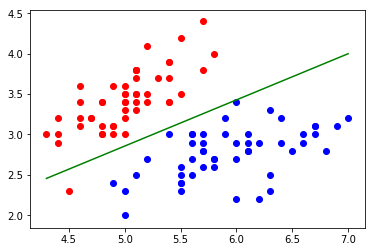

In [15]:
mydata.plot_boundary(mlr.w[:2], mlr.w[2])